Let's do the circus tent plots, for variations in the stellar parameters that govern the correlated noise model: 
- Prot: default is 4.86 days --> 8 or 28 days
- Tau: default is 100/sqrt(2) = 70ish days --> 3 or 30 days
- sigma_corr: default is 47 m/s -->  10 or 50 m/s
- eta: default is 0.4/sqrt(2) = 0.28 --> 0.1 or 0.9

This will become Fig 5 in the paper, which was formerly split between Figs 5 and 6.

In [20]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
from tqdm import tqdm
import pandas as pd
import random
import astropy 
from astropy.time import Time
from numpy.linalg import inv, det, solve, cond
from tinygp import kernels, GaussianProcess

import matplotlib.pyplot as plt
import matplotlib

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

from gaspery import calculate_fi, strategies, utils

path = '/Users/chrislam/Desktop/gaspery/'

1.26.2
1.11.4


In [21]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

In [22]:
random_generator = np.random.default_rng(seed=42)

# correlated noise parameters, from Klein+ 2021 for AU Mic
Prot = 4.86 # days
Tau = 100/np.sqrt(2) # active region lifetime; days
eta = 0.4/np.sqrt(2) # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
sigma_qp_rv = 47 # modified Jeffreys prior +11, -8 [m/s]
sigma_wn_rv = 5 # [m/s]

# planet parameters
K = 8.5 # m/s
K_err = 2.25 # m/s (average of +2.3, -2.2 m/s)
p = 8.46 # days
T0 = 2458651.993 # central transit time, in BJD, on 19 June 2019

### choose start time as date of this writing
start = '2023-03-01T10:00:00'
start = Time(start, format='isot', scale='utc').jd

### the parameter I'm varying
params = [Tau, eta, Prot, sigma_qp_rv, sigma_wn_rv]
theta = [K, p, T0]

In [23]:
# build covariance matrix kernel, characterized by a correlated noise model of the stellar signal
kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
kernel *= sigma_qp_rv**2 # multiply by scalar

### Star object and covariance matrix
star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                         Prot = Prot, sigma_qp_rv = sigma_qp_rv)

#### Beat frequencies, to trace lines on plots

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 199159.73it/s]


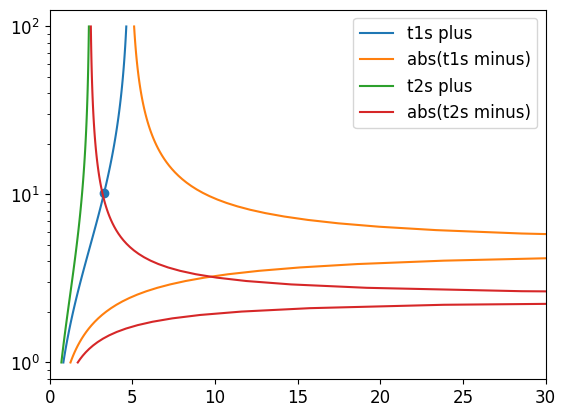

In [24]:
t1s_plus = []
t1s_minus = []
t2s_plus = []
t2s_minus = []
t2s_plus_porb = []
t2s_minus_porb = []
t3s_plus = []
t3s_minus = []
p = 8.46 

for i in tqdm(range(100)):
    c = cadences[i]
    p = periods[i]
    
    t1_plus = 1/((1/Prot) + (1/p))
    t1_minus = 1/((1/Prot) - (1/p))
    t1s_plus.append(t1_plus)
    t1s_minus.append(t1_minus)
    
    t2_plus = 1/((2/Prot) + (1/p))
    t2_minus = 1/((2/Prot) - (1/p))
    t2s_plus.append(t2_plus)
    t2s_minus.append(t2_minus)
    
    t3_plus = 1/((3/Prot) + (1/p))
    t3_minus = 1/((3/Prot) - (1/p))
    t3s_plus.append(t3_plus)
    t3s_minus.append(t3_minus)

    t2_plus_porb = 1/((1/Prot) + 0.5*(1/p))
    t2_minus_porb = 1/((1/Prot) - 0.5*(1/p))
    t2s_plus_porb.append(t2_plus_porb)
    t2s_minus_porb.append(t2_minus_porb)
    
plt.plot(t1s_plus, periods, label='t1s plus') # t3s_plus
plt.plot(np.abs(t1s_minus), periods, label='abs(t1s minus)')

plt.plot(t2s_plus, periods, label='t2s plus')
plt.plot(np.abs(t2s_minus), periods, label='abs(t2s minus)')

plt.scatter(3.3, 10.23)

#plt.plot(t1s_plus + np.abs(t1s_minus), periods, color='purple')
plt.xlim([0,30])
#plt.ylim([0, 100])
plt.yscale('log')
plt.legend()
plt.show()

#### Default parameters

In [116]:
dim = 100
# planet observation parameters
periods = np.logspace(0, 2, dim)
cadences = np.linspace(0.30, 6.85, dim)
n_obs = 30 #70
offs = []

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
fi_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))

for enum_o, o in enumerate(tqdm(periods)):
    for enum_c, c in enumerate(cadences):
                
        try:
            strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)
            strat = np.array(strategy.gappy(cadence=c)) 
            
            ### calculate FI and sigma_K
            sigma = star.cov_matrix_general(strat, kernel)
            sigma += 1e-6 

            theta = [K, o, T0]
            args = np.array(strat), sigma, jnp.array(theta, dtype=float)

            fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
            inv_fim = inv(fim)
            sigma_k = np.sqrt(inv_fim)[0][0]

            fi_k = fim[0][0]

            # for 2D plots and testing
            sigma_ks[enum_o][enum_c] = sigma_k
            ###sigma_ks_stable[enum1][enum2] = sigma_k_stable
            ###sigma_ks_solve[enum1][enum2] = sigma_k_solve

            fi_ks[enum_o][enum_c] = fi_k
                
        except Exception as e:
            print(e, o, c)
            sigma_ks[enum_o][enum_c] = np.nan
            fi_ks[enum_o][enum_c] = 0

  0%|                                                                                                                     | 0/100 [00:00<?, ?it/s]/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_45909/2260631382.py:32: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
 24%|█████████████████████████▉                                                                                  | 24/100 [00:08<00:27,  2.80it/s]


KeyboardInterrupt: 

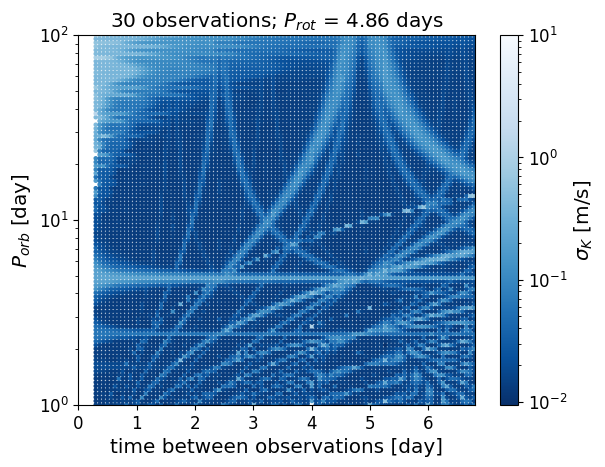

In [25]:
x, y = np.meshgrid(cadences, periods)
plt.scatter(x, y, c=sigma_ks/100, s=5, cmap='Blues_r',norm=matplotlib.colors.LogNorm(vmax=10)) # vmin=0.05*K, vmax=10*K
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_K$ [m/s]")
plt.xlabel("time between observations [day]")
plt.ylabel("$P_{orb}$ [day]")
plt.ylim([1, 100])
plt.xlim([0, 6.8])
plt.yscale('log')
plt.title(f"{n_obs} observations; " + r"$P_{rot}$ = " + f"{Prot} days")
plt.show()

#### $P_{rot}$ = 28 days

In [133]:
print(params)
params[2] = 28
Prot = 28
print(params)

# build covariance matrix kernel, characterized by a correlated noise model of the stellar signal
kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
kernel *= sigma_qp_rv**2 # multiply by scalar

### Star object and covariance matrix
star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                         Prot = Prot, sigma_qp_rv = sigma_qp_rv)

[70.71067811865474, 0.282842712474619, 4.86, 47, 5]
[70.71067811865474, 0.282842712474619, 28, 47, 5]


In [134]:
dim = 100
# planet observation parameters
periods = np.logspace(0, 2, dim)
cadences = np.linspace(0.30, 6.85, dim)
n_obs = 30 #70
offs = []

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
fi_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))

for enum_o, o in enumerate(tqdm(periods)):
    for enum_c, c in enumerate(cadences):
                
        try:
            strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)
            strat = np.array(strategy.gappy(cadence=c)) 
            
            ### calculate FI and sigma_K
            sigma = star.cov_matrix_general(strat, kernel)
            sigma += 1e-6 

            theta = [K, o, T0]
            args = np.array(strat), sigma, jnp.array(theta, dtype=float)

            fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
            inv_fim = inv(fim)
            sigma_k = np.sqrt(inv_fim)[0][0]

            fi_k = fim[0][0]

            # for 2D plots and testing
            sigma_ks[enum_o][enum_c] = sigma_k
            ###sigma_ks_stable[enum1][enum2] = sigma_k_stable
            ###sigma_ks_solve[enum1][enum2] = sigma_k_solve

            fi_ks[enum_o][enum_c] = fi_k
                
        except Exception as e:
            print(e, o, c)
            sigma_ks[enum_o][enum_c] = np.nan
            fi_ks[enum_o][enum_c] = 0

  0%|                                                                                                                     | 0/100 [00:00<?, ?it/s]/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_45909/2260631382.py:32: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.88it/s]


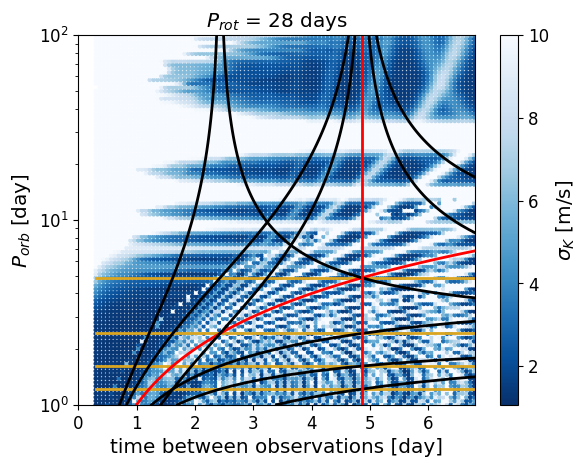

In [136]:
# plot lines
#"""
plt.plot(cadences, np.ones(len(cadences))*Prot, color='goldenrod', linewidth=2, linestyle='solid', label='integer ratios of $P_{rot}$')
plt.plot(cadences, np.ones(len(cadences))*Prot/2, color='goldenrod', linewidth=2, linestyle='solid')
plt.plot(cadences, np.ones(len(cadences))*Prot/3, color='goldenrod', linewidth=2, linestyle='solid')
plt.plot(cadences, np.ones(len(cadences))*Prot/4, color='goldenrod', linewidth=2, linestyle='solid')

plt.plot(cadences, cadences, color='red', linestyle='solid', linewidth=2, label='observing once per $P_{orb}$')

plt.plot(t1s_plus, periods, color='k', linestyle='solid', linewidth=2, label='beat freq between $P_{rot}$ and $P_{orb}$') # t3s_plus
plt.plot(np.abs(t1s_minus), periods, color='k', linewidth=2, linestyle='solid')

plt.plot(t2s_plus, periods, color='k', linestyle='solid', linewidth=2, label='beat freq between $P_{rot}$/2 and $P_{orb}$') # t3s_plus
plt.plot(np.abs(t2s_minus), periods, linestyle='solid', linewidth=2, color='k')

plt.plot(t2s_plus_porb, periods, color='k', linestyle='solid', linewidth=2, label='beat freq between $P_{rot}$ and 2$P_{orb}$') # t3s_plus
plt.plot(np.abs(t2s_minus_porb), periods, color='k', linewidth=2, linestyle='solid')

plt.plot(np.ones(100)*4.86, np.linspace(1, 100, 100), color='red', linestyle='solid', linewidth=2, label='cadence = $P_{rot}$')
#"""

# plot map
x, y = np.meshgrid(cadences, periods)
#plt.scatter(x, y, c=sigma_ks, s=5, cmap='Blues_r',norm=matplotlib.colors.LogNorm(vmax=10)) # vmin=0.05*K, vmax=10*K
plt.scatter(x, y, c=sigma_ks, s=5, cmap='Blues_r',vmax=10) # vmin=0.05*K, vmax=10*K
cbar = plt.colorbar(ticks=[2,4,6,8,10])
cbar.ax.set_ylabel(r"$\sigma_K$ [m/s]")
plt.xlabel("time between observations [day]")
plt.ylabel("$P_{orb}$ [day]")
plt.ylim([1, 100])
plt.xlim([0, 6.8])
plt.yscale('log')
plt.title(r"$P_{rot}$ = " + "28 days")
plt.savefig(path+'plots/prot28.png')
plt.show()

#### $\tau$ = 30 days

In [11]:
### reset
params[2] = 4.86
Prot = 4.86

print(params)
params[0] = 10 # 30
Tau = params[0]
print(params)

# build covariance matrix kernel, characterized by a correlated noise model of the stellar signal
kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
kernel *= sigma_qp_rv**2 # multiply by scalar

### Star object and covariance matrix
star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                         Prot = Prot, sigma_qp_rv = sigma_qp_rv)

[3, 0.282842712474619, 4.86, 47, 5]
[10, 0.282842712474619, 4.86, 47, 5]


In [12]:
dim = 100
# planet observation parameters
periods = np.logspace(0, 2, dim)
cadences = np.linspace(0.30, 6.85, dim)
n_obs = 30 #70
offs = []

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
fi_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))

for enum_o, o in enumerate(tqdm(periods)):
    for enum_c, c in enumerate(cadences):
                
        try:
            strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)
            strat = np.array(strategy.gappy(cadence=c)) 
            
            ### calculate FI and sigma_K
            sigma = star.cov_matrix_general(strat, kernel)
            sigma += 1e-6 

            theta = [K, o, T0]
            args = np.array(strat), sigma, jnp.array(theta, dtype=float)

            fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
            inv_fim = inv(fim)
            sigma_k = np.sqrt(inv_fim)[0][0]

            fi_k = fim[0][0]

            # for 2D plots and testing
            sigma_ks[enum_o][enum_c] = sigma_k
            ###sigma_ks_stable[enum1][enum2] = sigma_k_stable
            ###sigma_ks_solve[enum1][enum2] = sigma_k_solve

            fi_ks[enum_o][enum_c] = fi_k
                
        except Exception as e:
            print(e, o, c)
            sigma_ks[enum_o][enum_c] = np.nan
            fi_ks[enum_o][enum_c] = 0

  0%|                                                                               | 0/100 [00:00<?, ?it/s]/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_73991/2260631382.py:32: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.90it/s]


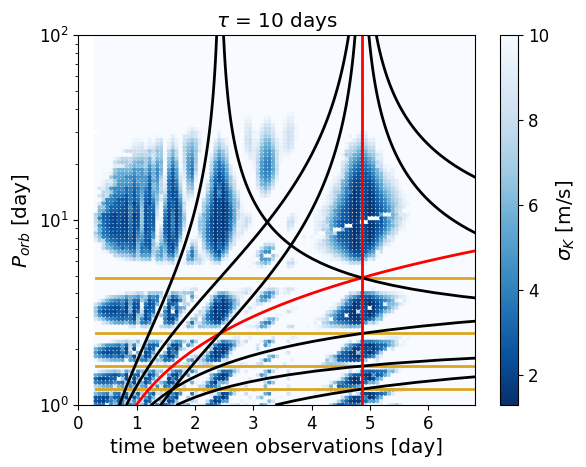

In [13]:
# plot lines
#"""
plt.plot(cadences, np.ones(len(cadences))*Prot, color='goldenrod', linewidth=2, linestyle='solid', label='integer ratios of $P_{rot}$')
plt.plot(cadences, np.ones(len(cadences))*Prot/2, color='goldenrod', linewidth=2, linestyle='solid')
plt.plot(cadences, np.ones(len(cadences))*Prot/3, color='goldenrod', linewidth=2, linestyle='solid')
plt.plot(cadences, np.ones(len(cadences))*Prot/4, color='goldenrod', linewidth=2, linestyle='solid')

plt.plot(cadences, cadences, color='red', linestyle='solid', linewidth=2, label='observing once per $P_{orb}$')

plt.plot(t1s_plus, periods, color='k', linestyle='solid', linewidth=2, label='beat freq between $P_{rot}$ and $P_{orb}$') # t3s_plus
plt.plot(np.abs(t1s_minus), periods, color='k', linewidth=2, linestyle='solid')

plt.plot(t2s_plus, periods, color='k', linestyle='solid', linewidth=2, label='beat freq between $P_{rot}$/2 and $P_{orb}$') # t3s_plus
plt.plot(np.abs(t2s_minus), periods, linestyle='solid', linewidth=2, color='k')

plt.plot(t2s_plus_porb, periods, color='k', linestyle='solid', linewidth=2, label='beat freq between $P_{rot}$ and 2$P_{orb}$') # t3s_plus
plt.plot(np.abs(t2s_minus_porb), periods, color='k', linewidth=2, linestyle='solid')

plt.plot(np.ones(100)*4.86, np.linspace(1, 100, 100), color='red', linestyle='solid', linewidth=2, label='cadence = $P_{rot}$')
#"""

# plot map
x, y = np.meshgrid(cadences, periods)
#plt.scatter(x, y, c=sigma_ks, s=5, cmap='Blues_r',norm=matplotlib.colors.LogNorm(vmax=10)) # vmin=0.05*K, vmax=10*K
plt.scatter(x, y, c=sigma_ks, s=5, cmap='Blues_r',vmax=10) # vmin=0.05*K, vmax=10*K
cbar = plt.colorbar(ticks=[2,4,6,8,10])
cbar.ax.set_ylabel(r"$\sigma_K$ [m/s]")
plt.xlabel("time between observations [day]")
plt.ylabel("$P_{orb}$ [day]")
plt.ylim([1, 100])
plt.xlim([0, 6.8])
plt.yscale('log')
plt.title(r"$\tau$ = " + "10 days")
plt.savefig(path+'plots/tau10.png')
plt.show()

#### $\sigma_{corr}$ = 10 m/s 

In [14]:
### reset
params[0] = 100/np.sqrt(2)
Tau = params[0]
params[2] = 4.86
Prot = 4.86

print(params)
params[3] = 5 # 10
sigma_qp_rv = params[3]
print(params)

# build covariance matrix kernel, characterized by a correlated noise model of the stellar signal
kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
kernel *= sigma_qp_rv**2 # multiply by scalar

### Star object and covariance matrix
star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                         Prot = Prot, sigma_qp_rv = sigma_qp_rv)

[70.71067811865474, 0.282842712474619, 4.86, 47, 5]
[70.71067811865474, 0.282842712474619, 4.86, 5, 5]


In [15]:
dim = 100
# planet observation parameters
periods = np.logspace(0, 2, dim)
cadences = np.linspace(0.30, 6.85, dim)
n_obs = 30 #70
offs = []

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
fi_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))

for enum_o, o in enumerate(tqdm(periods)):
    for enum_c, c in enumerate(cadences):
                
        try:
            strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)
            strat = np.array(strategy.gappy(cadence=c)) 
            
            ### calculate FI and sigma_K
            sigma = star.cov_matrix_general(strat, kernel)
            sigma += 1e-6 

            theta = [K, o, T0]
            args = np.array(strat), sigma, jnp.array(theta, dtype=float)

            fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
            inv_fim = inv(fim)
            sigma_k = np.sqrt(inv_fim)[0][0]

            fi_k = fim[0][0]

            # for 2D plots and testing
            sigma_ks[enum_o][enum_c] = sigma_k
            ###sigma_ks_stable[enum1][enum2] = sigma_k_stable
            ###sigma_ks_solve[enum1][enum2] = sigma_k_solve

            fi_ks[enum_o][enum_c] = fi_k
                
        except Exception as e:
            print(e, o, c)
            sigma_ks[enum_o][enum_c] = np.nan
            fi_ks[enum_o][enum_c] = 0

  0%|                                                                               | 0/100 [00:00<?, ?it/s]/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_73991/2260631382.py:32: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.81it/s]


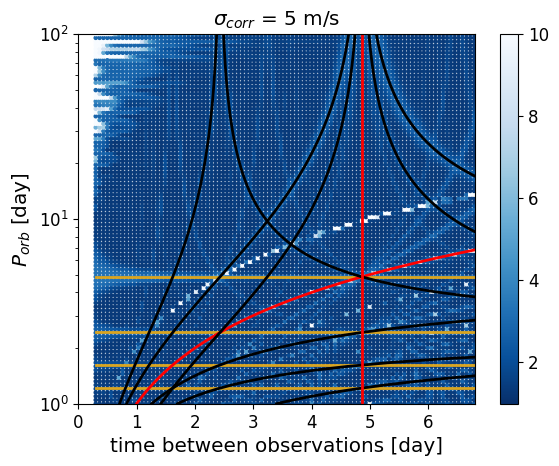

In [16]:
# plot lines
#"""
plt.plot(cadences, np.ones(len(cadences))*Prot, color='goldenrod', linewidth=2, linestyle='solid', label='integer ratios of $P_{rot}$')
plt.plot(cadences, np.ones(len(cadences))*Prot/2, color='goldenrod', linewidth=2, linestyle='solid')
plt.plot(cadences, np.ones(len(cadences))*Prot/3, color='goldenrod', linewidth=2, linestyle='solid')
plt.plot(cadences, np.ones(len(cadences))*Prot/4, color='goldenrod', linewidth=2, linestyle='solid')

plt.plot(cadences, cadences, color='red', linestyle='solid', linewidth=2, label='observing once per $P_{orb}$')

plt.plot(t1s_plus, periods, color='k', linestyle='solid', linewidth=2, label='beat freq between $P_{rot}$ and $P_{orb}$') # t3s_plus
plt.plot(np.abs(t1s_minus), periods, color='k', linewidth=2, linestyle='solid')

plt.plot(t2s_plus, periods, color='k', linestyle='solid', linewidth=2, label='beat freq between $P_{rot}$/2 and $P_{orb}$') # t3s_plus
plt.plot(np.abs(t2s_minus), periods, linestyle='solid', linewidth=2, color='k')

plt.plot(t2s_plus_porb, periods, color='k', linestyle='solid', linewidth=2, label='beat freq between $P_{rot}$ and 2$P_{orb}$') # t3s_plus
plt.plot(np.abs(t2s_minus_porb), periods, color='k', linewidth=2, linestyle='solid')

plt.plot(np.ones(100)*4.86, np.linspace(1, 100, 100), color='red', linestyle='solid', linewidth=2, label='cadence = $P_{rot}$')
#"""

# plot map
x, y = np.meshgrid(cadences, periods)
#plt.scatter(x, y, c=sigma_ks, s=5, cmap='Blues_r',norm=matplotlib.colors.LogNorm(vmax=10)) # vmin=0.05*K, vmax=10*K
plt.scatter(x, y, c=sigma_ks, s=5, cmap='Blues_r', vmax=10) # vmin=0.05*K, vmax=10*K
#cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_K$ [m/s]")
cbar = plt.colorbar(ticks=[2,4,6,8,10])
plt.xlabel("time between observations [day]")
plt.ylabel("$P_{orb}$ [day]")
plt.ylim([1, 100])
plt.xlim([0, 6.8])
plt.yscale('log')
plt.title(r"$\sigma_{corr}$ = " + "5 m/s")
plt.savefig(path+'plots/sigma_corr5.png')
plt.show()

#### $\eta$ = 0.9

In [26]:
### reset
params[3] = 47
sigma_qp_rv = params[3]

print(params)
params[1] = 0.9/np.sqrt(2)
eta = params[1]
print(params)

# build covariance matrix kernel, characterized by a correlated noise model of the stellar signal
kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
kernel *= sigma_qp_rv**2 # multiply by scalar

### Star object and covariance matrix
star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                         Prot = Prot, sigma_qp_rv = sigma_qp_rv)

[70.71067811865474, 0.282842712474619, 4.86, 47, 5]
[70.71067811865474, 0.6363961030678927, 4.86, 47, 5]


In [27]:
dim = 100
# planet observation parameters
periods = np.logspace(0, 2, dim)
cadences = np.linspace(0.30, 6.85, dim)
n_obs = 30 #70
offs = []

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
fi_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))

for enum_o, o in enumerate(tqdm(periods)):
    for enum_c, c in enumerate(cadences):
                
        try:
            strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)
            strat = np.array(strategy.gappy(cadence=c)) 
            
            ### calculate FI and sigma_K
            sigma = star.cov_matrix_general(strat, kernel)
            sigma += 1e-6 

            theta = [K, o, T0]
            args = np.array(strat), sigma, jnp.array(theta, dtype=float)

            fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
            inv_fim = inv(fim)
            sigma_k = np.sqrt(inv_fim)[0][0]

            fi_k = fim[0][0]

            # for 2D plots and testing
            sigma_ks[enum_o][enum_c] = sigma_k
            ###sigma_ks_stable[enum1][enum2] = sigma_k_stable
            ###sigma_ks_solve[enum1][enum2] = sigma_k_solve

            fi_ks[enum_o][enum_c] = fi_k
                
        except Exception as e:
            print(e, o, c)
            sigma_ks[enum_o][enum_c] = np.nan
            fi_ks[enum_o][enum_c] = 0

  0%|                                                                                                                                                         | 0/100 [00:00<?, ?it/s]/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_73991/2260631382.py:32: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.86it/s]


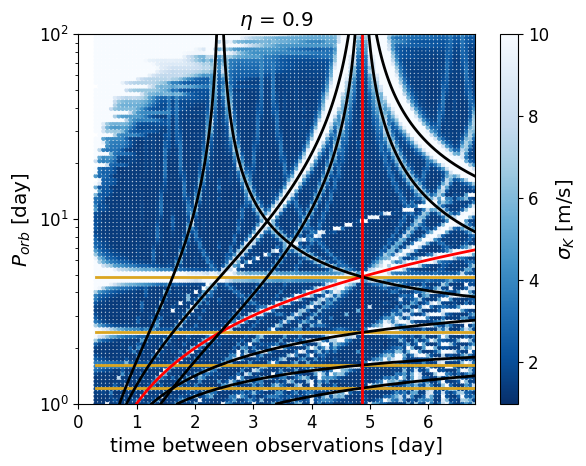

In [28]:
# plot lines
#"""
plt.plot(cadences, np.ones(len(cadences))*Prot, color='goldenrod', linewidth=2, linestyle='solid', label='integer ratios of $P_{rot}$')
plt.plot(cadences, np.ones(len(cadences))*Prot/2, color='goldenrod', linewidth=2, linestyle='solid')
plt.plot(cadences, np.ones(len(cadences))*Prot/3, color='goldenrod', linewidth=2, linestyle='solid')
plt.plot(cadences, np.ones(len(cadences))*Prot/4, color='goldenrod', linewidth=2, linestyle='solid')

plt.plot(cadences, cadences, color='red', linestyle='solid', linewidth=2, label='observing once per $P_{orb}$')

plt.plot(t1s_plus, periods, color='k', linestyle='solid', linewidth=2, label='beat freq between $P_{rot}$ and $P_{orb}$') # t3s_plus
plt.plot(np.abs(t1s_minus), periods, color='k', linewidth=2, linestyle='solid')

plt.plot(t2s_plus, periods, color='k', linestyle='solid', linewidth=2, label='beat freq between $P_{rot}$/2 and $P_{orb}$') # t3s_plus
plt.plot(np.abs(t2s_minus), periods, linestyle='solid', linewidth=2, color='k')

plt.plot(t2s_plus_porb, periods, color='k', linestyle='solid', linewidth=2, label='beat freq between $P_{rot}$ and 2$P_{orb}$') # t3s_plus
plt.plot(np.abs(t2s_minus_porb), periods, color='k', linewidth=2, linestyle='solid')

plt.plot(np.ones(100)*4.86, np.linspace(1, 100, 100), color='red', linestyle='solid', linewidth=2, label='cadence = $P_{rot}$')
#"""

# plot map
x, y = np.meshgrid(cadences, periods)
#plt.scatter(x, y, c=sigma_ks, s=5, cmap='Blues_r', norm=matplotlib.colors.LogNorm(vmax=10)) # vmin=0.05*K, vmax=10*K
plt.scatter(x, y, c=sigma_ks, s=5, cmap='Blues_r', vmax=10) # vmin=0.05*K, vmax=10*K
cbar = plt.colorbar(ticks=[2,4,6,8,10])
#cbar = plt.colorbar(ticks=[1,5,10], format=formatter)
#cbar.set_ticklabels([1,5,10])
cbar.ax.set_ylabel(r"$\sigma_K$ [m/s]")
plt.xlabel("time between observations [day]")
plt.ylabel("$P_{orb}$ [day]")
plt.ylim([1, 100])
plt.xlim([0, 6.8])
plt.yscale('log')
plt.title(r"$\eta$ = " + "0.9")
plt.savefig(path+'plots/eta09.png')
plt.show()

What about in viridis?

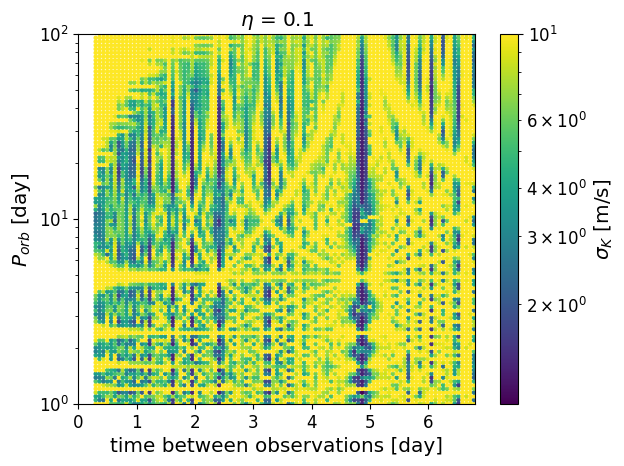

In [65]:
x, y = np.meshgrid(cadences, periods)
plt.scatter(x, y, c=sigma_ks, s=5,norm=matplotlib.colors.LogNorm(vmax=10)) # vmin=0.05*K, vmax=10*K
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_K$ [m/s]")
plt.xlabel("time between observations [day]")
plt.ylabel("$P_{orb}$ [day]")
plt.ylim([1, 100])
plt.xlim([0, 6.8])
plt.yscale('log')
plt.title(r"$\eta$ = " + "0.1")
#plt.savefig(path+'plots/eta01.png')
plt.show()